# Interoperability via MCP

What is Model Context Protocol and how does it help to extend and simplify agentic systems? 


<img src="img/0.png" alt="Agent using tools" width="750">

Agents are truly useful only after they start to interact with the real world - they do it using tools!

<img src="img/1.png" alt="Equip your agent" width="750">

MCP is the universal way to expose tools to your agents!

<img src="img/2.png" alt="MCP Anthropic" width="750">

Anthropic, one of leading AI companies introduced MCP as open source standard for agentic tool usage.  

In [12]:
MCP_SERVER_URL = "http://127.0.0.1:8000/mcp"

### Discovery - the hard way
Let's see that behind the MCP server magic there is standard JSON-RPC protocol

In [13]:
import requests

COMMON_HEADERS = {
    "Accept": "application/json, text/event-stream",
    "Content-Type": "application/json",
    "MCP-Protocol-Version": "2025-06-18",
}

def rcp_post(method, params=None, headers=None, id_=1):
    payload = {"jsonrpc": "2.0", "id": id_, "method": method}
    if params is not None:
        payload["params"] = params
    r = requests.post(MCP_SERVER_URL, json=payload, headers= headers or COMMON_HEADERS, timeout=10)
    r.raise_for_status()
    return r

# 1) Initialize 
init_resp = rcp_post(
    "initialize",
    {
        "protocolVersion": "2025-06-18",
        "capabilities": {},
        "clientInfo": {"name": "demo-client", "version": "0.1.0"},
    }
)

# 2) Capture session id from response headers
session_id = init_resp.headers.get("Mcp-Session-Id")
HEADERS_WITH_SESSION = {**COMMON_HEADERS, "Mcp-Session-Id": session_id}

# 3) Send notifications/initialized (notification: no id required)
notif = requests.post(
    MCP_SERVER_URL,
    json={"jsonrpc": "2.0", "method": "notifications/initialized"},
    headers=HEADERS_WITH_SESSION,
    timeout=10,
)
notif.raise_for_status()

# 4) discovery = tools/list
tools_resp = rcp_post("tools/list", {}, headers=HEADERS_WITH_SESSION, id_=2)
tools_resp.text

'event: message\r\ndata: {"jsonrpc":"2.0","id":2,"result":{"tools":[{"name":"add","description":"Return the sum of two numbers.","inputSchema":{"properties":{"a":{"title":"A","type":"integer"},"b":{"title":"B","type":"integer"}},"required":["a","b"],"title":"addArguments","type":"object"},"outputSchema":{"properties":{"result":{"title":"Result","type":"integer"}},"required":["result"],"title":"addOutput","type":"object"}},{"name":"subtract","description":"Return the subtraction of two numbers.","inputSchema":{"properties":{"a":{"title":"A","type":"integer"},"b":{"title":"B","type":"integer"}},"required":["a","b"],"title":"subtractArguments","type":"object"},"outputSchema":{"properties":{"result":{"title":"Result","type":"integer"}},"required":["result"],"title":"subtractOutput","type":"object"}}]}}\r\n\r\n'

### Discovery - the easy way

In [14]:
from mcp import ClientSession
from mcp.client.streamable_http import streamablehttp_client

from langchain_mcp_adapters.tools import load_mcp_tools



async with streamablehttp_client(MCP_SERVER_URL) as (read, write, _):
    async with ClientSession(read, write) as session:
        await session.initialize()
        tools = await load_mcp_tools(session)

tools

[StructuredTool(name='add', description='Return the sum of two numbers.', args_schema={'properties': {'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}, 'required': ['a', 'b'], 'title': 'addArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x000002C6AB852520>),
 StructuredTool(name='subtract', description='Return the subtraction of two numbers.', args_schema={'properties': {'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}, 'required': ['a', 'b'], 'title': 'subtractArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x000002C6AB8523E0>)]

### Tool calls

In [15]:
async with streamablehttp_client(MCP_SERVER_URL) as (read, write, _):
    async with ClientSession(read, write) as session:
        await session.initialize()
        tools = await load_mcp_tools(session)

        result = await tools[0].ainvoke({"a": 2, "b": 3})

result

'5'

### Agent Calling Tools

Let's initialize our connection to MCP server without Python context manager and pass the tools to LangGrpah agent

In [16]:
# Quick connection example without context manager - in real application would require session cleanup!

from mcp import ClientSession
from mcp.client.streamable_http import streamablehttp_client

client_ctx = streamablehttp_client(MCP_SERVER_URL)
read, write, _ = await client_ctx.__aenter__()   # manual enter

session_ctx = ClientSession(read, write)
session = await session_ctx.__aenter__()
await session.initialize()

InitializeResult(meta=None, protocolVersion='2025-06-18', capabilities=ServerCapabilities(experimental={}, logging=None, prompts=PromptsCapability(listChanged=False), resources=ResourcesCapability(subscribe=False, listChanged=False), tools=ToolsCapability(listChanged=False), completions=None), serverInfo=Implementation(name='barts-mcp-server', title=None, version='1.12.2'), instructions=None)

In [17]:
tools = await load_mcp_tools(session)
tools

[StructuredTool(name='add', description='Return the sum of two numbers.', args_schema={'properties': {'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}, 'required': ['a', 'b'], 'title': 'addArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x000002C6AB6F68E0>),
 StructuredTool(name='subtract', description='Return the subtraction of two numbers.', args_schema={'properties': {'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}, 'required': ['a', 'b'], 'title': 'subtractArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x000002C6AB6F77E0>)]

In [18]:
import utils

# Set API key to env variable
utils.init_openai()

In [19]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000002C6AB839E90>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000002C6AB83ACD0>, root_client=<openai.OpenAI object at 0x000002C6AB842510>, root_async_client=<openai.AsyncOpenAI object at 0x000002C6A9B41C90>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'))

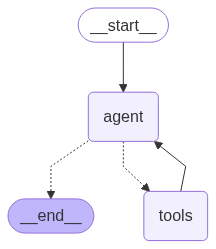

In [20]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver


memory = MemorySaver()
agent = create_react_agent(llm, tools, checkpointer=memory)
agent

### Let's talk it over

In [21]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "1"}}

# Script:
m1 = "Hey! Can you use some tools? Maybe you can list them to me?"
m2 = "That is great. Can you add for me 2 and 4?"
m3 ="Surprise me, take numbers 2 and 3 and get some new number from them by doing the following:\
    Perform 2 mathematical operations on numbers 2 and 3, whichever you like. \
    Then do 3rd and final operation where two inputs will be results of previous operations. \
    Return the final result to me as a number and tell me why you like it."


messages = await agent.ainvoke({"messages": HumanMessage(content=m3)}, config) # type: ignore
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Surprise me, take numbers 2 and 3 and get some new number from them by doing the following:    Perform 2 mathematical operations on numbers 2 and 3, whichever you like.     Then do 3rd and final operation where two inputs will be results of previous operations.     Return the final result to me as a number and tell me why you like it.
================================== Ai Message ==================================
Tool Calls:
  add (call_LmXnj9TswLta3N8ux7jZTVqn)
 Call ID: call_LmXnj9TswLta3N8ux7jZTVqn
  Args:
    a: 2
    b: 3
  subtract (call_wRbWbH1FQn7b0f8irglEm9fq)
 Call ID: call_wRbWbH1FQn7b0f8irglEm9fq
  Args:
    a: 3
    b: 2
================================= Tool Message =================================
Name: add

5
================================= Tool Message =================================
Name: subtract

1
================================== Ai Message ==================================
T